<a href="https://colab.research.google.com/github/sahil301290/SyntheticFaceDetector/blob/main/M2_ProposedCNN_DeepFake.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Sun Apr 14 14:26:53 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0              25W / 300W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import zipfile
import glob
import os

# Define the source directory where the zip files are located
source_dir = '/content/drive/MyDrive/Datasets/Deepfake/'
# Define the destination directory where you want to extract the files
destination_dir = '/content/'

# Find all zip files in the source directory
zip_files = glob.glob(os.path.join(source_dir, '*.zip'))

# Unzip each file into the destination directory
for zip_file in zip_files:
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(destination_dir)
    print(f'Extracted {zip_file} to {destination_dir}')

Extracted /content/drive/MyDrive/Datasets/Deepfake/FFHQ Dataset.zip to /content/
Extracted /content/drive/MyDrive/Datasets/Deepfake/FakeFaces-128px.zip to /content/
Extracted /content/drive/MyDrive/Datasets/Deepfake/microsoft-FaceSynthetics-128px.zip to /content/
Extracted /content/drive/MyDrive/Datasets/Deepfake/Deepfake-Synthetic-20K Dataset - 128px.zip to /content/


In [3]:
!mv /content/content/FakeFaces-128px /content/FakeFaces-128px
!rm -rf /content/content
os.rename("/content/thumbnails128x128", "/content/FFHQ-128px") if os.path.exists("/content/thumbnails128x128") else "Folder does not exist."

In [4]:
import shutil

# Define source folders
source_folders = {
    "real": "/content/FFHQ-128px",
    "fake": [
        "/content/microsoft-FaceSynthetics-128px",
        "/content/Deepfake-Synthetic-20K Dataset - 128px",
        "/content/FakeFaces-128px"
    ]
}

# Define target directories
target_directories = {
    "real": "/content/dataset/real/",
    "fake": "/content/dataset/fake/"
}

# Create target directories if they don't exist
for target in target_directories.values():
    os.makedirs(target, exist_ok=True)

# Move the FFHQ folder to /content/Real/
shutil.move(source_folders["real"], target_directories["real"])

# Move the other folders to /content/Fake/
for folder in source_folders["fake"]:
    shutil.move(folder, target_directories["fake"])

# Check if the operations were successful by listing the directories
directories_listing = {
    "real": os.listdir(target_directories["real"]),
    "fake": os.listdir(target_directories["fake"])
}

directories_listing

{'real': ['FFHQ-128px'],
 'fake': ['microsoft-FaceSynthetics-128px',
  'Deepfake-Synthetic-20K Dataset - 128px',
  'FakeFaces-128px']}

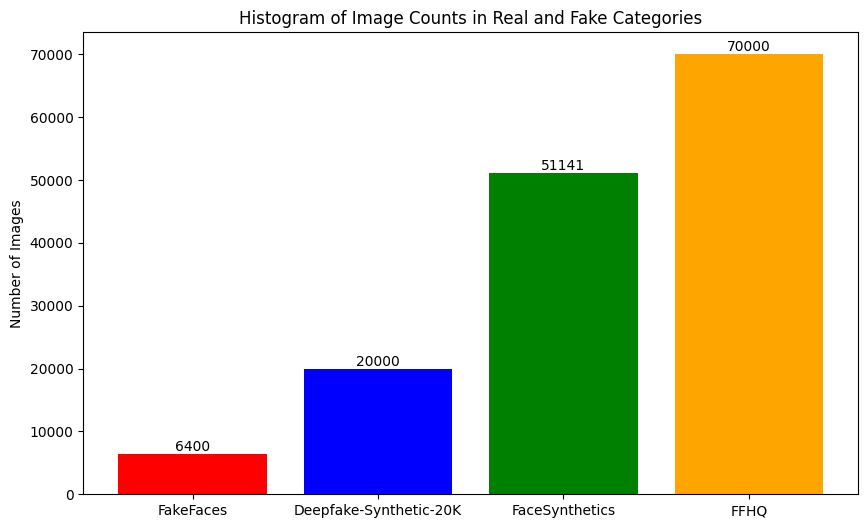

In [5]:
import os
import matplotlib.pyplot as plt

# Updated paths to datasets
folders = {
    'FakeFaces': '/content/dataset/fake/FakeFaces-128px',
    'Deepfake-Synthetic-20K': '/content/dataset/fake/Deepfake-Synthetic-20K Dataset - 128px',
    'FaceSynthetics': '/content/dataset/fake/microsoft-FaceSynthetics-128px',
    'FFHQ': '/content/dataset/real/FFHQ-128px'
}

# Initialize counts
image_counts = {}

# Count the number of images in each dataset folder
for folder_name, folder_path in folders.items():
    image_counts[folder_name] = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])

# Plotting
labels = image_counts.keys()
counts = image_counts.values()

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, counts, color=['red', 'blue', 'green', 'orange'])

# Add the count above each bar for clarity
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width() / 2.0, count, int(count), ha='center', va='bottom')

#plt.xlabel('Dataset')
plt.ylabel('Number of Images')
plt.title('Histogram of Image Counts in Real and Fake Categories')
plt.savefig('/content/CountHistogram.png', dpi=300)
plt.savefig('/content/CountHistogram.pdf', dpi=300)
plt.show()

In [6]:
import tensorflow as tf

# Assuming the base directory is correctly set
base_dir = '/content/dataset/'

# Define parameters for dataset loading
batch_size = 32
img_height = 128
img_width = 128

# Load the entire dataset, without specifying a subset for validation
all_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    labels="inferred",
    label_mode="binary",
    class_names=["fake", "real"],
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
)

# Determine the dataset size
dataset_size = tf.data.experimental.cardinality(all_ds).numpy()

# Split sizes directly calculated from the total dataset
test_batches = int(dataset_size * 0.4)
val_batches = int(dataset_size * 0.4)
train_batches = dataset_size - test_batches - val_batches  # This needs to be adjusted to reflect the correct calculation

# Adjusting the total dataset size to reflect the number of images based on batches
total_images_counted = (test_batches + val_batches + train_batches) * batch_size

# Print the initial dataset size and the total images accounted for in the split
print(f"Initial dataset size: {dataset_size * batch_size} images")
print(f"Total images accounted for in splits: {total_images_counted} images")

# Split the datasets
test_ds = all_ds.take(test_batches)
remaining_ds = all_ds.skip(test_batches)
val_ds = remaining_ds.take(val_batches)
train_ds = remaining_ds.skip(val_batches)

# Performance configurations
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Print counts
print(f"Training dataset: {train_batches * batch_size} images")
print(f"Validation dataset: {val_batches * batch_size} images")
print(f"Test dataset: {test_batches * batch_size} images")

Found 147541 files belonging to 2 classes.
Initial dataset size: 147552 images
Total images accounted for in splits: 147552 images
Training dataset: 29536 images
Validation dataset: 59008 images
Test dataset: 59008 images


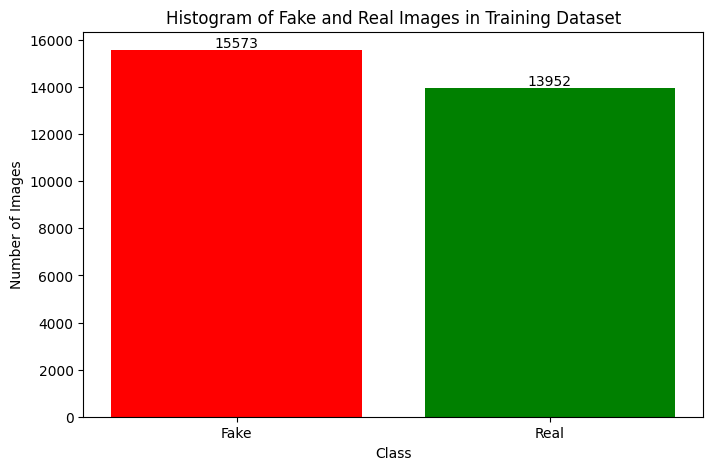

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize counters
fake_count = 0
real_count = 0

# Iterate through the training dataset to count labels
for images, labels in train_ds.unbatch():  # unbatch() returns individual samples
    labels = labels.numpy()  # Convert to numpy array for easy counting
    # Count fake and real
    fake_count += np.sum(labels == 0)
    real_count += np.sum(labels == 1)

# Data to plot
labels = ['Fake', 'Real']
counts = [fake_count, real_count]

# Create the histogram
plt.figure(figsize=(8, 5))
plt.bar(labels, counts, color=['red', 'green'])

# Add the count above each bar
for i, count in enumerate(counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Histogram of Fake and Real Images in Training Dataset')
plt.savefig('/content/TrainBalance.png', dpi=300)
plt.savefig('/content/TrainBalance.pdf', dpi=300)
plt.show()

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the CNN model
def define_model():
    model = models.Sequential([
        layers.Rescaling(1./255, input_shape=(128, 128, 3)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

# Define the model
model = define_model()

# Model summary
model.summary()

# Define callback for early stopping
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=[early_stopping_callback]
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        1

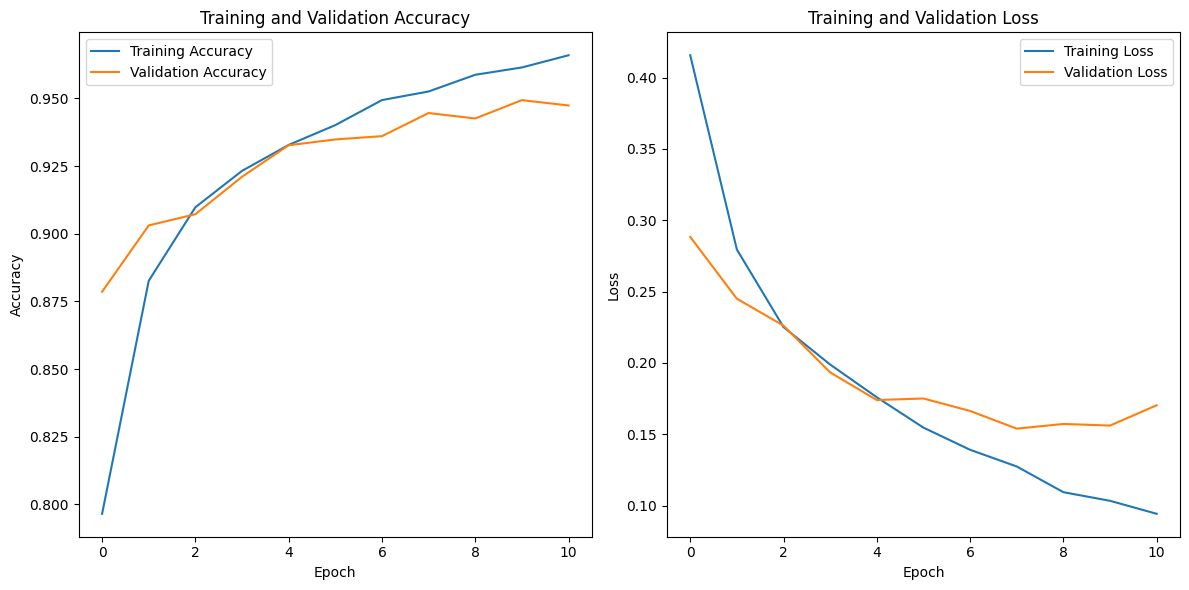

In [9]:
# Plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('/content/ConvergencePlot.png', dpi=300)
plt.savefig('/content/ConvergencePlot.pdf', dpi=300)
plt.show()

In [10]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Prepare true labels and predictions
y_true = []
y_scores = []  # For ROC and PR curves

for images, labels in test_ds.unbatch():
    preds = model.predict(tf.expand_dims(images, axis=0),verbose=0)
    y_scores.append(preds[0])
    y_true.append(labels.numpy())

y_pred = np.round(y_scores).astype(int)  # Convert probabilities to binary predictions

1844/1844 [==============================] - 13s 7ms/step - loss: 0.1692 - accuracy: 0.9473
Test Loss: 0.1691637635231018
Test Accuracy: 0.9472783207893372


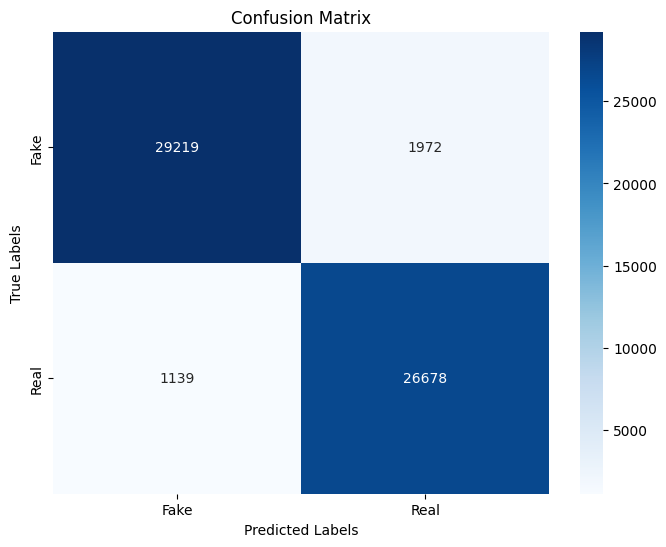

              precision    recall  f1-score   support

        Fake       0.96      0.94      0.95     31191
        Real       0.93      0.96      0.94     27817

    accuracy                           0.95     59008
   macro avg       0.95      0.95      0.95     59008
weighted avg       0.95      0.95      0.95     59008



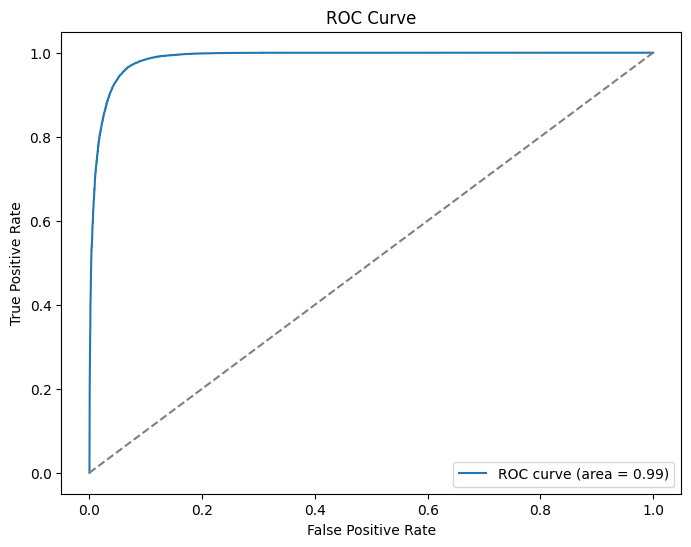

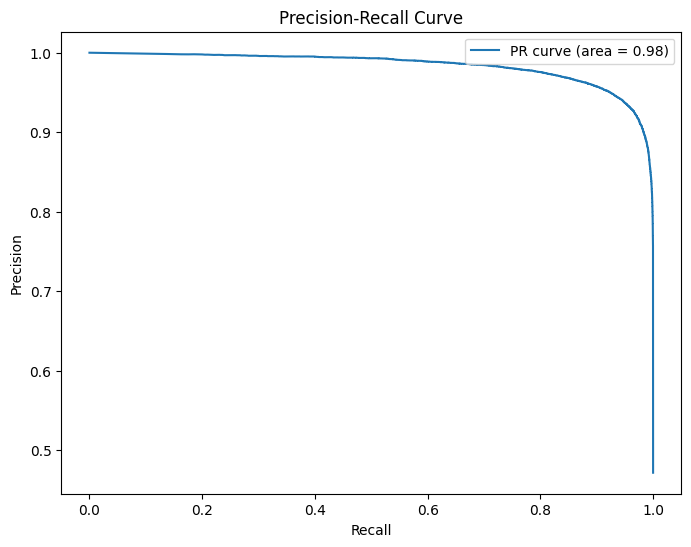

In [11]:
# Generating the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('/content/ConfusionMatrix.png', dpi=300)
plt.savefig('/content/ConfusionMatrix.pdf', dpi=300)
plt.show()

# Generating and printing the classification report
print(classification_report(y_true, y_pred, target_names=['Fake', 'Real']))

# Calculate and plot ROC AUC
roc_auc = roc_auc_score(y_true, y_scores)
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.savefig('/content/ROC_Curve.png', dpi=300)
plt.savefig('/content/ROC_Curve.pdf', dpi=300)
plt.show()

# Calculate and plot Precision-Recall Curve and AUC
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
pr_auc = auc(recall, precision)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.savefig('/content/PR_Curve.png', dpi=300)
plt.savefig('/content/PR_Curve.pdf', dpi=300)
plt.show()